In [34]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from ml_utils import *

def imshow(img):
    plt.imshow(img)
    plt.axis('off')  # 可选：不显示坐标轴
    plt.title('Example Image')  # 可选：加标题
    plt.show()
def show_images(imgs, num_rows, num_cols, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)  # 图像整体尺寸
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)  # 创建子图网格
    axes = axes.flatten()  # 将二维坐标轴变成一维，方便迭代
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if isinstance(img, torch.Tensor):
            # 把形状从 (C, H, W) 转成 (H, W, C)，用于 matplotlib 显示
            img = img.permute(1, 2, 0).detach().numpy()
        ax.imshow(img)           # 显示图像
        ax.axes.get_xaxis().set_visible(False)  # 不显示x轴刻度
        ax.axes.get_yaxis().set_visible(False)  # 不显示y轴刻度
    plt.tight_layout()  # 自动调整子图间距
    plt.show()



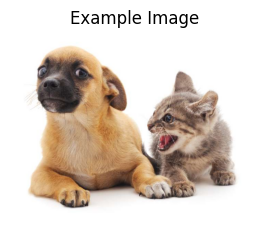

In [35]:

set_figsize()
# 1️⃣ 设置图片路径（确保存在）
img_path = '../asset/catdog.jpg'

from PIL import Image
img = Image.open(img_path)


# 4️⃣ 显示原图
imshow(img)

In [36]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale=scale)

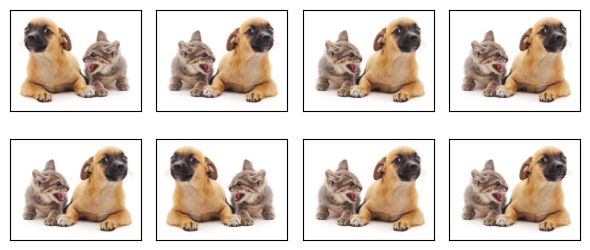

In [37]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

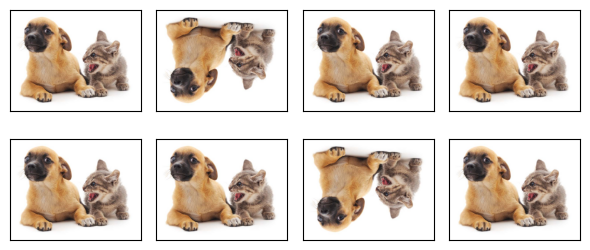

In [38]:
apply(img, torchvision.transforms.RandomVerticalFlip())

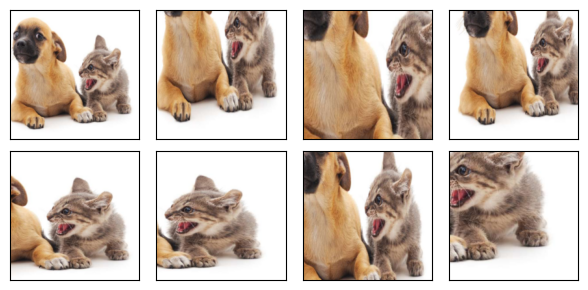

In [39]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    # 输出图像的尺寸（高度, 宽度）
    (200, 200),
    # 随机裁剪区域面积相对于原图面积的比例范围	(0.1, 1) 表示裁剪区域面积占原图面积的 10% ~ 100%
    scale=(0.1, 1),
    # 裁剪区域的高宽比范围（height / width）	(0.5, 2) 表示高度可以是宽度的 0.5 ~ 2 倍
    ratio=(0.5, 2))
apply(img, shape_aug)

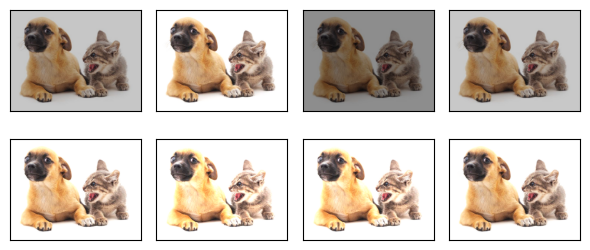

In [40]:
#另一种增广方法是改变颜色。 我们可以改变图像颜色的四个方面：亮度、对比度、饱和度和色调。 在下面的示例中，我们随机更改图像的亮度，随机值为原始图像的50%（1-0.5）到150%（1+0.5）之间。
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

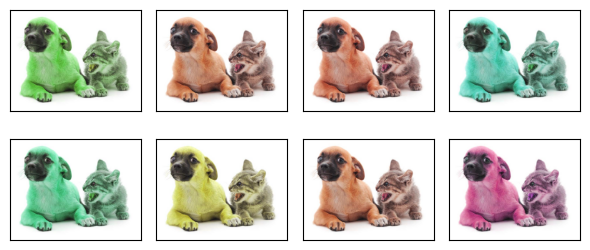

In [41]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

In [42]:
# 四个指标都随机改变
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.05)

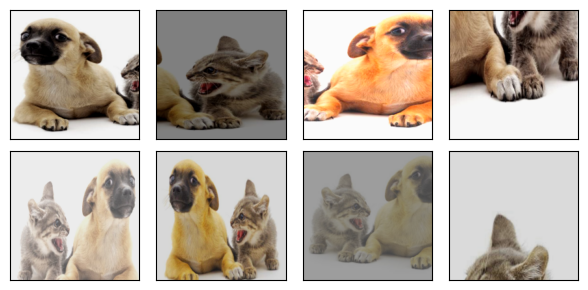

In [43]:
# 组合
apply(img, torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    shape_aug,
    color_aug
]))

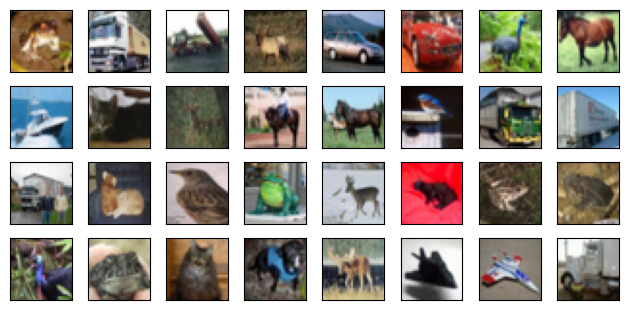

In [44]:
# 下载数据集
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [45]:
train_augs = torchvision.transforms.Compose([
    # 只做了水平翻转
     torchvision.transforms.RandomHorizontalFlip(),
    # 把他们变成一个4D的张量
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [46]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    # 正常来说num_workers需要设置大一点，因为图片的augment很消耗性能
                    shuffle=is_train, num_workers=4)
    return dataloader

In [47]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum



In [48]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = Timer(), len(train_iter)
    # animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
    #                         legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            # if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                # animator.add(epoch + (i + 1) / num_batches,
                #              (metric[0] / metric[2], metric[1] / metric[3],
                #               None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        # animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [49]:
batch_size, devices, net = 256, try_all_gpus(), resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

In [50]:
# 可以有效降低过拟合
train_with_data_aug(train_augs, test_augs, net)

loss 0.451, train acc 0.843, test acc 0.750
13182.9 examples/sec on [device(type='cuda', index=0)]


In [51]:
train_with_data_aug(test_augs, test_augs, net)

loss 0.076, train acc 0.973, test acc 0.717
12939.3 examples/sec on [device(type='cuda', index=0)]
